#### Predicting import/export and exchange between Germany and France

# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
import lightgbm as lgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit
from utils import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [73]:
df = pd.read_csv('x_train.csv').set_index('ID').sort_index()
y = pd.read_csv('y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('x_test.csv').set_index('ID')

de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]

fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]

full = df.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE'].drop(['DAY_ID', 'COUNTRY'], axis=1)
full_fr = full[full['COUNTRY'] == 'FR'].drop(['DAY_ID', 'COUNTRY'], axis=1)

# fix wind
fr_left_wind_mean, fr_left_wind_std = full_fr.loc[:1656, ['FR_WIND', 'DE_WIND']].mean(), full_fr.loc[:1656, ['FR_WIND', 'DE_WIND']].std()
fr_right_wind_mean, fr_right_wind_std = full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']].mean(), full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']].std()
full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']] = (((full_fr.loc[1724:, ['FR_WIND', 'DE_WIND']] - fr_right_wind_mean) / fr_right_wind_std) * fr_left_wind_std) + fr_left_wind_mean

de_wind_gap = pd.read_csv('de_wind_reconstructed_gap.csv').set_index('ID').sort_index()
fr_wind_gap = pd.read_csv('fr_wind_reconstructed_gap.csv').set_index('ID').sort_index()
full_fr.loc[fr_wind_gap.index, 'FR_WIND'] = fr_wind_gap['0']
full_fr.loc[de_wind_gap.index, 'DE_WIND'] = de_wind_gap['0']

de_import_gap = full_fr[full_fr['DE_NET_IMPORT'].isna()].index
fr_import_gap = full_fr[full_fr['FR_NET_IMPORT'].isna()].index
exchange_gap = full_fr[full_fr['DE_FR_EXCHANGE'].isna()].index

full_de_norm = full_de.copy()
full_de_norm = (full_de_norm - full_de_norm.mean()) / full_de_norm.std()

full_fr_norm = full_fr.copy()
full_fr_norm = (full_fr_norm - full_fr_norm.mean()) / full_fr_norm.std()

In [72]:
full_fr.loc[de_import_gap]

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
932,0.931983,0.946786,NaN,NaN,NaN,NaN,NaN,NaN,-0.279936,-0.388614,-1.116400,-0.777920,-0.702349,0.090513,0.224166,1.238111,-1.348875,-1.242489,3.053773,2.739401,-0.887516,-1.611834,0.422827,4.965032,1.183322,0.495189,0.658659,0.949327,1.533169,-0.509720,0.100740,-0.235452
933,0.880508,0.881603,NaN,NaN,NaN,NaN,NaN,NaN,0.066808,-0.344762,-0.006085,-0.776396,-0.576288,0.554155,0.663309,1.283956,-1.399163,-1.235034,1.413867,2.436178,0.050227,-0.192107,0.427023,2.034344,2.127580,-0.205264,0.123975,1.075974,1.835761,-0.355296,-0.301449,-0.220830
934,0.683673,0.813651,NaN,NaN,NaN,NaN,NaN,NaN,0.223300,-0.097421,0.166830,-0.778026,-0.731163,0.831906,0.520983,1.386685,-1.279730,-1.100344,1.107618,0.801223,0.296333,-0.093060,0.702082,0.979414,0.967726,-0.365213,-0.608444,1.465248,1.605309,0.317321,0.050629,-0.551201
935,1.231695,1.269656,NaN,NaN,NaN,NaN,NaN,NaN,0.541972,0.726137,-0.262330,-0.121198,-1.075728,0.690618,0.820342,1.557844,-1.122654,-1.179317,1.251842,0.322378,1.091601,0.097374,1.264296,-1.228214,0.962364,-0.462356,-0.364924,-1.044338,0.456897,0.078996,-0.606772,0.270359
936,1.408520,1.391108,NaN,NaN,NaN,NaN,NaN,NaN,0.736501,0.963235,0.019075,0.327328,-0.820520,0.932772,0.689873,1.760980,-1.134702,-1.054363,1.072079,-0.158598,0.963711,0.377162,1.486483,-0.967634,0.555446,-0.510427,-0.985396,-0.885387,-0.298126,-0.236740,0.616277,0.787153
937,1.075988,1.276328,NaN,NaN,NaN,NaN,NaN,NaN,1.414906,1.116439,1.391492,0.658796,-0.682110,0.756215,0.812531,1.854408,-1.024976,-1.006239,-0.683238,-0.277055,1.369470,1.659356,1.391707,-0.679139,0.036572,-1.324837,-0.784565,-0.282143,0.513167,-0.435396,0.556208,0.131572
938,1.130684,1.382883,NaN,NaN,NaN,NaN,NaN,NaN,2.094486,1.308504,1.854485,1.046438,-0.542329,0.871242,0.830429,1.850732,-1.246615,-0.983346,-1.214830,-0.703833,1.384592,2.232390,1.590333,0.119506,-0.170922,-1.506387,-0.851370,-0.133840,0.128882,-0.199062,-0.349016,-0.357618
939,1.029520,1.508218,NaN,NaN,NaN,NaN,NaN,NaN,1.609834,1.285000,1.633809,1.154614,-0.357097,0.992382,0.817392,1.695485,-1.375129,-0.967741,-0.756592,-0.810292,1.233358,1.803529,1.736401,-0.489411,-0.211100,-1.326968,-1.019282,-0.505300,-0.062024,0.319347,0.201223,1.046748
940,1.489934,1.576587,NaN,NaN,NaN,NaN,NaN,NaN,0.423125,0.699534,-0.665022,-0.317316,-0.647637,0.787315,0.676800,1.593847,-1.123865,-1.183434,2.130791,2.085412,0.399380,-0.500313,1.193379,-0.134913,1.141601,-0.124698,-0.298330,-0.584097,0.143271,-0.357743,-0.300298,-1.325776


In [3]:
full_fr[full_fr.index.isin(fr_wind_gap.index)]

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1657,0.789367,2.023643,2.197203,-2.197203,1.105777,-1.780434,-1.105777,1.780434,1.624260,1.663172,-0.008884,0.133754,0.060703,1.299060,-0.078085,1.095300,-1.450159,-1.086241,0.470569,-0.189442,0.243512,0.639883,2.161360,NaN,NaN,-0.644922,-0.900284,NaN,NaN,0.682637,1.057258,1.224726
1658,1.021339,2.237380,2.495411,-2.495411,1.134751,-1.616863,-1.134751,1.616863,1.932549,1.919507,0.347985,0.296298,0.200141,2.586607,0.046322,1.087867,-1.442296,-1.194894,0.370722,-0.262677,0.477996,0.884387,2.392852,NaN,NaN,-0.666136,-0.921531,NaN,NaN,-4.269256,-0.770407,-2.868455
1659,0.621926,2.261159,1.743034,-1.743034,0.267362,-1.691992,-0.267362,1.691992,2.054023,2.063663,0.659524,0.696617,-0.615736,2.679881,0.202849,1.136006,-1.427140,-0.972609,-0.342873,-0.631142,0.413651,1.226444,2.475473,NaN,NaN,-0.857959,-1.021752,NaN,NaN,-0.429607,0.721945,-0.766894
1660,1.058364,2.335423,1.976357,-1.976357,-0.214021,-1.570298,0.214021,1.570298,2.426421,2.185752,0.968407,1.209990,0.842106,3.364177,0.219927,1.157400,-1.415586,-0.695635,-0.696637,-0.624432,0.579002,1.836831,2.537454,NaN,NaN,-0.949869,-1.021363,NaN,NaN,2.590490,1.186364,2.946484
1661,0.922049,2.333348,1.277670,-1.277670,-0.374810,-1.167448,0.374810,1.167448,2.711776,2.267040,0.940112,1.211683,-0.054381,3.755666,0.215484,1.155260,-1.401194,-0.468982,-0.808878,-0.588282,0.547426,1.838511,2.513394,NaN,NaN,-0.974743,-1.012982,NaN,NaN,2.363348,0.164690,1.253967
1662,1.759370,2.432090,1.130185,-1.130185,0.946258,-1.120062,-0.946258,1.120062,1.029457,2.083620,-0.094703,1.243060,0.213862,2.987544,-0.028099,1.155462,-1.237168,-0.478245,1.828750,0.661909,-0.036047,0.029680,2.343126,NaN,NaN,-0.235602,-0.674688,NaN,NaN,-0.296080,-0.399210,2.841211
1663,1.805389,2.178594,0.823826,-0.823826,1.299341,0.113097,-1.299341,-0.113097,1.002709,1.974587,-0.031204,1.184342,-0.679538,2.724560,-0.032631,1.045754,-1.367067,-1.067882,1.995841,2.388932,-0.372722,-0.034717,1.712034,NaN,NaN,-0.183009,-0.208566,NaN,NaN,2.976056,0.140961,4.575306
1664,1.851717,1.650085,0.770745,-0.770745,1.323036,0.308021,-1.323036,-0.308021,0.506032,1.905167,-0.250736,0.897297,-1.158224,2.620839,-0.088235,0.931180,-1.213075,-0.900257,2.591416,1.353553,-0.418173,-0.589277,1.432348,NaN,NaN,-0.011433,-0.482348,NaN,NaN,-0.896412,-1.087599,-3.967640
1665,1.605983,1.459767,-0.448453,0.448453,-0.244380,0.662073,0.244380,-0.662073,2.047218,1.587278,0.500876,0.931639,-0.787418,2.140750,0.197330,1.041784,-1.358709,-0.869714,0.110550,2.191060,0.537166,1.477422,1.048016,NaN,NaN,-0.694766,-0.254335,NaN,NaN,-0.539853,-0.133094,-0.173480


In [4]:
full_fr.count()

DE_CONSUMPTION      1216
FR_CONSUMPTION      1216
DE_FR_EXCHANGE      1182
FR_DE_EXCHANGE      1182
DE_NET_EXPORT       1045
FR_NET_EXPORT       1122
DE_NET_IMPORT       1045
FR_NET_IMPORT       1122
DE_GAS              1216
FR_GAS              1216
DE_COAL             1216
FR_COAL             1216
DE_HYDRO            1216
FR_HYDRO            1216
DE_NUCLEAR          1216
FR_NUCLEAR          1216
DE_SOLAR            1216
FR_SOLAR            1216
DE_WINDPOW          1216
FR_WINDPOW          1216
DE_LIGNITE          1216
DE_RESIDUAL_LOAD    1216
FR_RESIDUAL_LOAD    1216
DE_RAIN             1149
FR_RAIN             1149
DE_WIND             1216
FR_WIND             1216
DE_TEMP             1149
FR_TEMP             1149
GAS_RET             1216
COAL_RET            1216
CARBON_RET          1216
dtype: int64

In [5]:
full_cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO',
       'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW',
       'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD',
       'DE_WIND', 'FR_WIND', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

<Axes: xlabel='ID', ylabel='FR_CONSUMPTION'>

<Figure size 640x480 with 0 Axes>

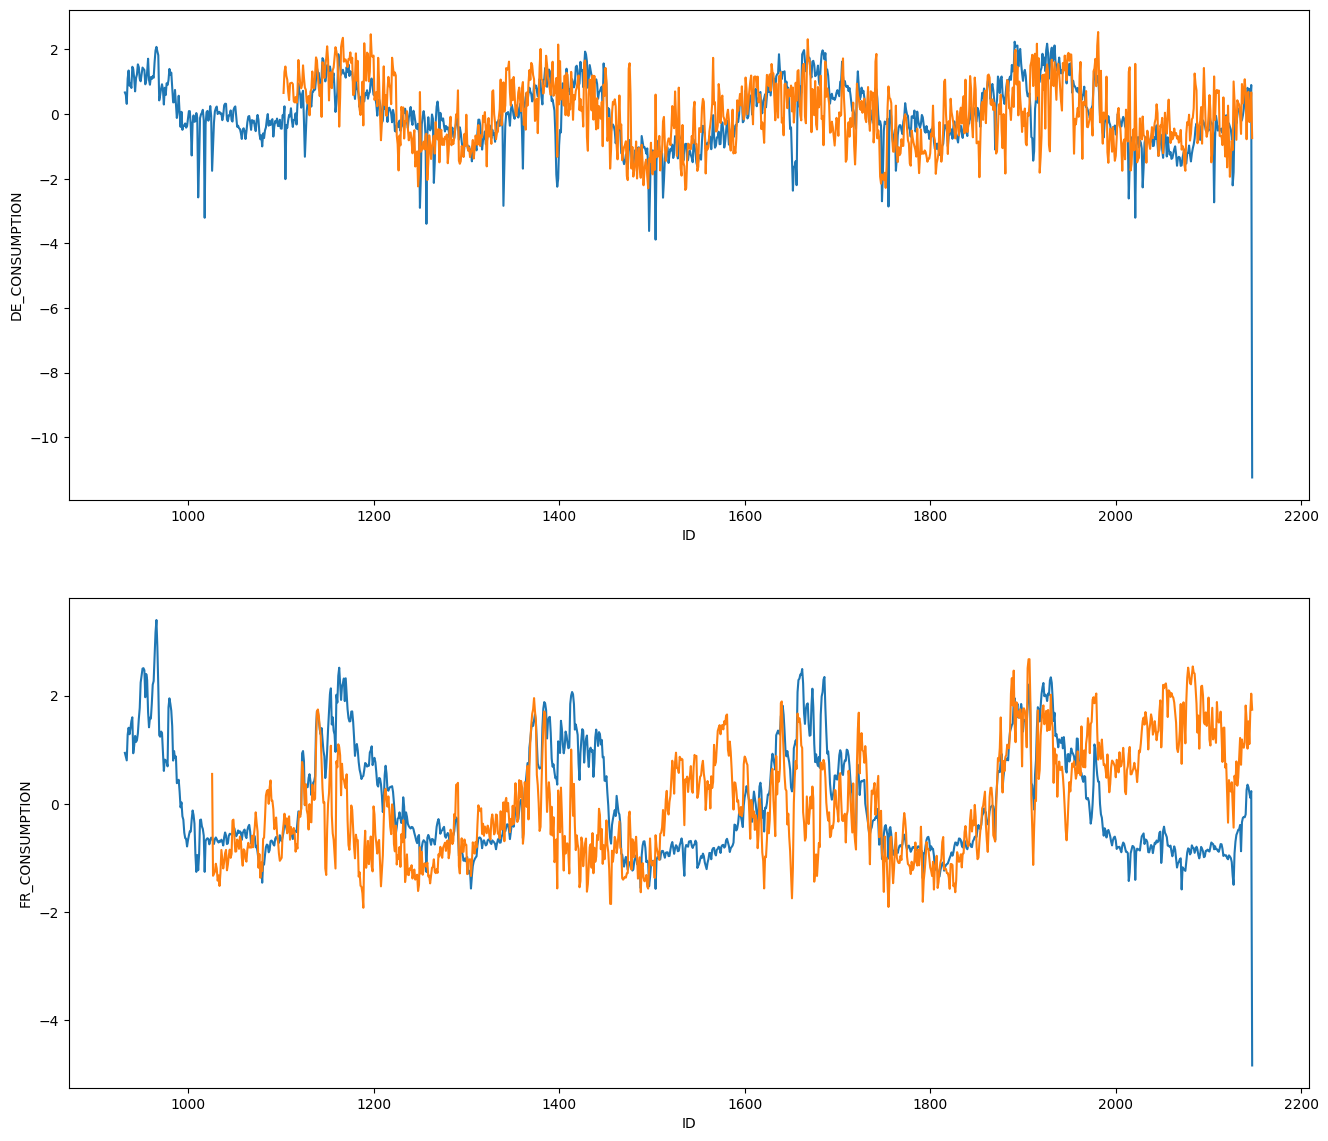

In [6]:
plt.figure()
fig, ax = plt.subplots(2, figsize=(16, 14))
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_CONSUMPTION'], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_NET_EXPORT'], ax=ax[0])

sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_CONSUMPTION'], ax=ax[1])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['FR_NET_IMPORT'], ax=ax[1])

<Axes: xlabel='DE_WIND', ylabel='DE_WINDPOW'>

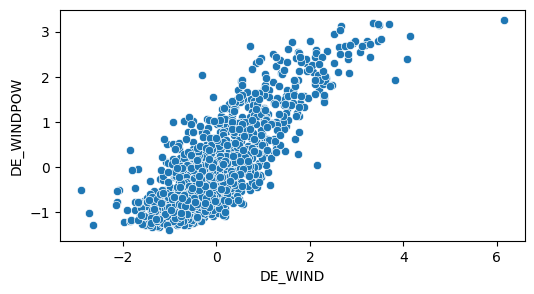

In [137]:
fig, ax = plt.subplots(1, figsize=(6, 3))
# temp = make_wind_sqcb(full_fr_norm, drop_wind=False)
# temp['DE_WIND_CBRT'] = np.cbrt(temp['DE_WIND'] + 1000)
# sns.scatterplot(data=temp, x='DE_WIND_CBRT', y='DE_WINDPOW', ax=ax[0])
# sns.scatterplot(data=temp, x='DE_WIND_SQCB', y='DE_WINDPOW', ax=ax[1])
sns.scatterplot(data=full_fr_norm, x='DE_WIND', y='DE_WINDPOW')

<Axes: xlabel='ID', ylabel='DE_WINDPOW'>

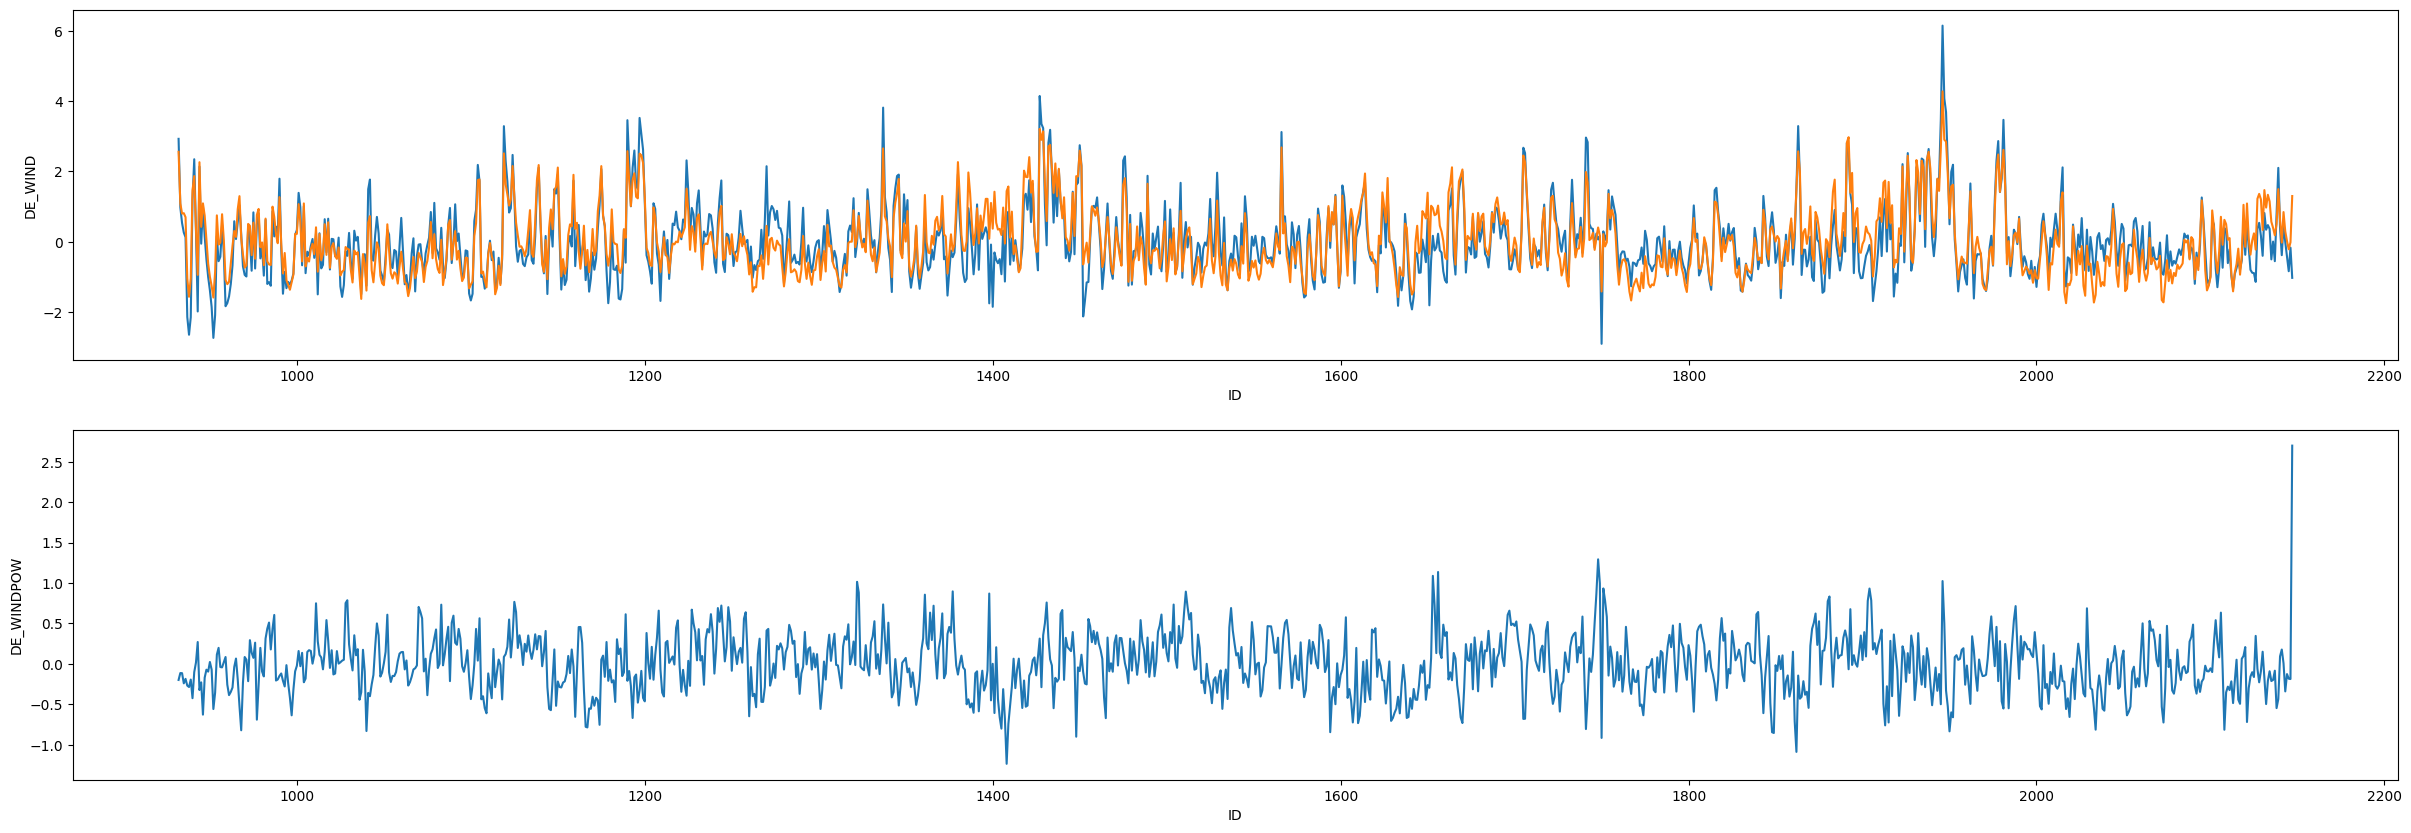

In [174]:
fig, ax = plt.subplots(2, figsize=(30, 10))
ridge = linear_model.Ridge()
# ridge.fit(np.array(full_fr_norm['DE_WIND']).reshape(-1, 1), full_fr_norm['DE_WINDPOW'])
# windpow_forecast = ridge.predict(np.array(full_fr_norm['DE_WIND']).reshape(-1, 1))
windpow_cols = ['DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_SOLAR', 'FR_SOLAR', 'DE_LIGNITE',
       'DE_WIND', 'FR_WIND']
ridge.fit(full_fr_norm[windpow_cols], full_fr_norm['DE_WINDPOW'])
windpow_forecast = ridge.predict(full_fr_norm[windpow_cols])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_WIND'], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=windpow_forecast, ax=ax[0])
# sns.lineplot(x=full_fr_norm.index, y=full_fr_norm['DE_WINDPOW'], ax=ax[0])
# sns.lineplot(x=full_fr_norm.index, y=windpow_forecast, ax=ax[0])
residual = windpow_forecast - full_fr_norm['DE_WINDPOW']
sns.lineplot(x=full_fr_norm.index, y=residual, ax=ax[1])

In [173]:
pd.DataFrame(data=ridge.coef_, index=windpow_cols).sort_values(0)

,0
DE_GAS,-0.343741
DE_COAL,-0.224674
DE_SOLAR,-0.201533
DE_LIGNITE,-0.179759
FR_HYDRO,-0.098561
DE_HYDRO,-0.087930
FR_SOLAR,-0.067749
FR_WIND,-0.030174
FR_COAL,-0.012193
FR_CONSUMPTION,0.141212


<Axes: xlabel='ID'>

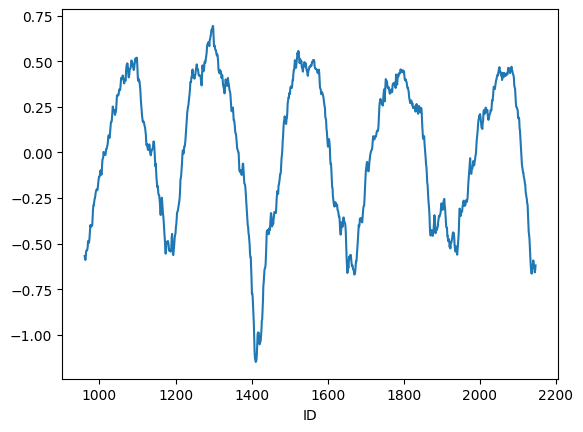

In [154]:
(windpow_forecast - full_fr_norm['DE_WINDPOW']).rolling(window=30).mean().plot()

In [116]:
full_fr_norm['DE_WIND'].describe()

count    1.216000e+03
mean    -1.700577e-15
std      1.000000e+00
min     -2.902175e+00
25%     -6.491780e-01
50%     -1.601865e-01
75%      4.823249e-01
max      6.147173e+00
Name: DE_WIND, dtype: float64

0.9601618742058098


<Figure size 640x480 with 0 Axes>

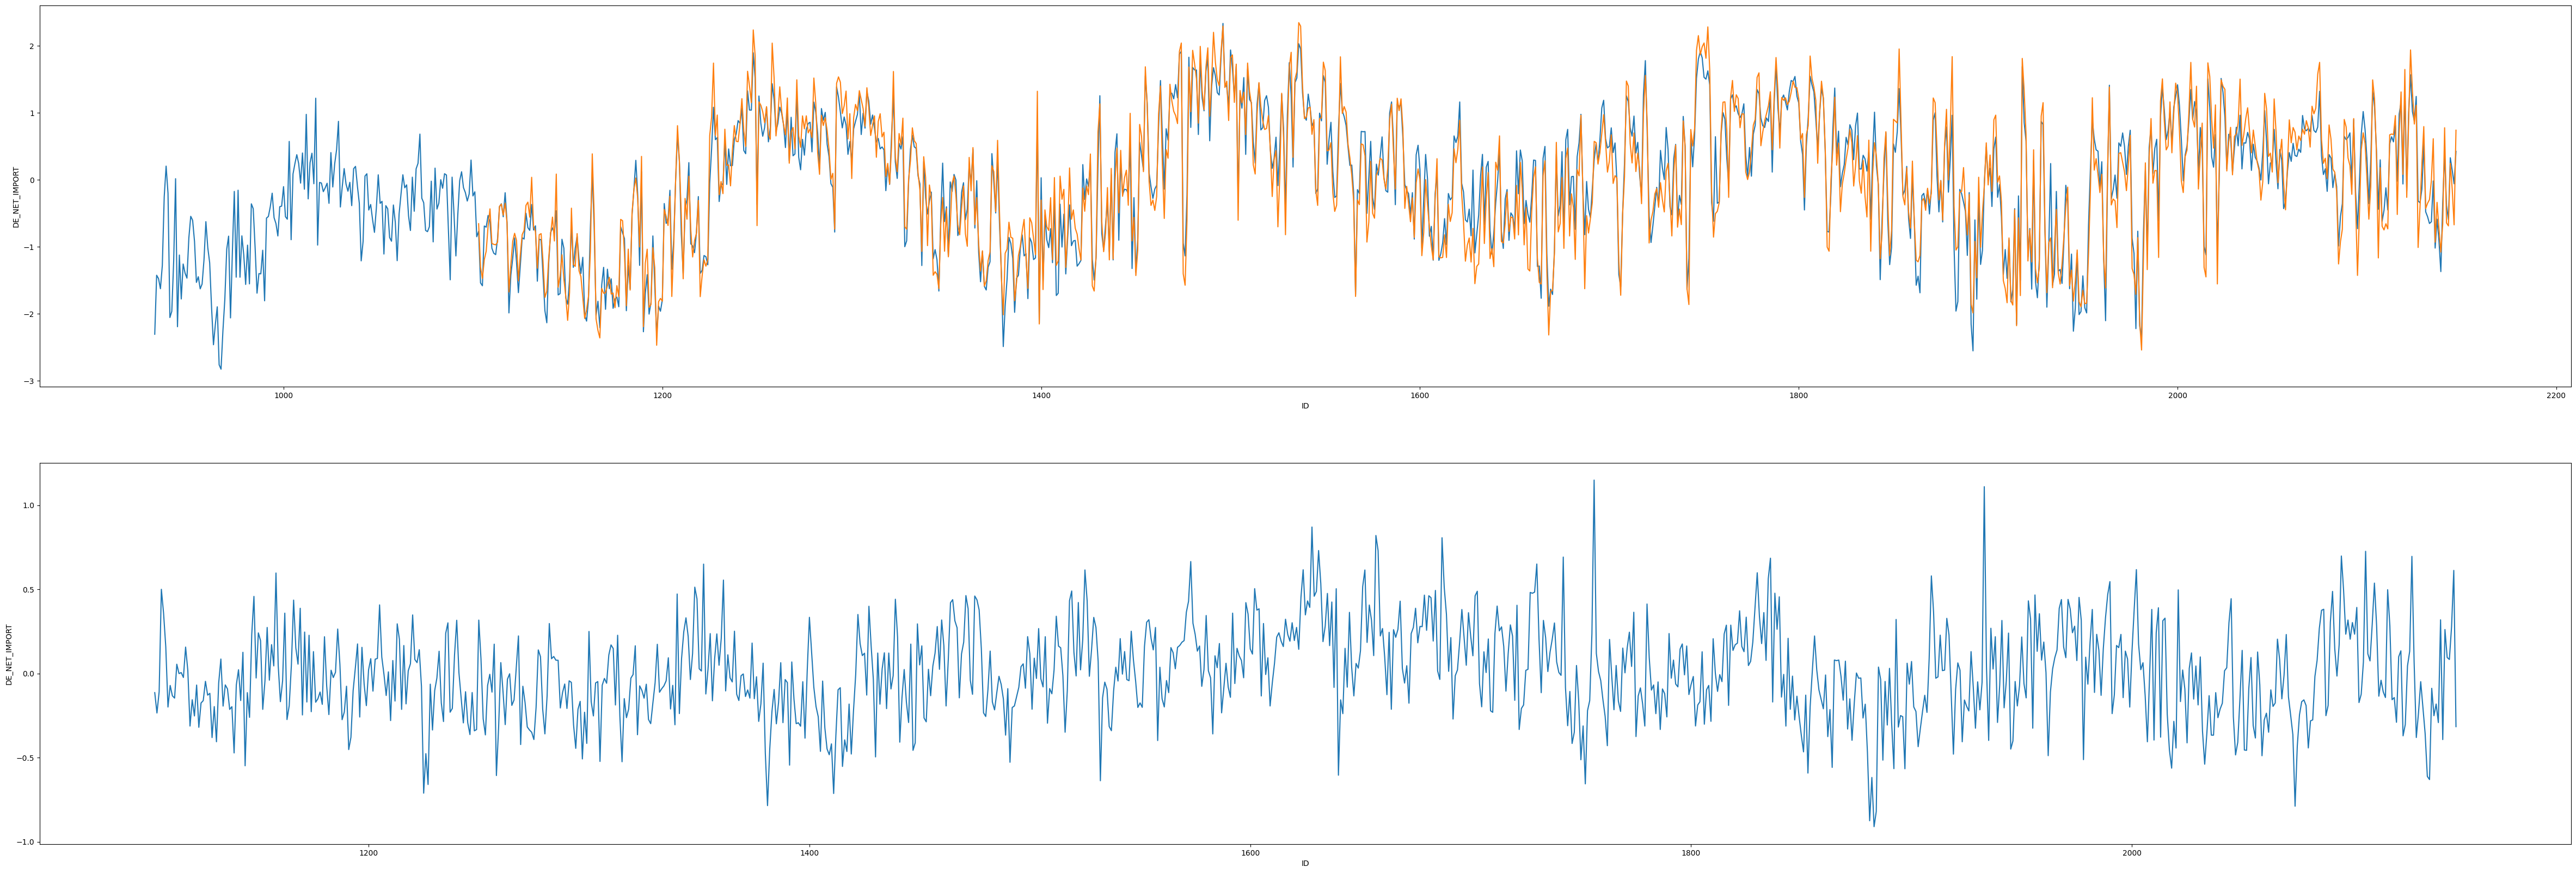

In [74]:
# regress target_col on columns, chosen by heatmap
# cols = ['DE_WINDPOW', 'FR_RESIDUAL_LOAD']
cols = full_cols
target_col = 'DE_NET_IMPORT'
ridge = linear_model.Ridge(alpha=1)
nona_idx = full_fr_norm[target_col].dropna().index[:]
exchange_train = full_fr_norm[full_fr_norm.index.isin(nona_idx)][cols]
exchange_target = full_fr_norm[full_fr_norm.index.isin(nona_idx)][target_col]
exchange_fit = full_fr_norm[cols].copy()
ridge.fit(exchange_train, exchange_target)
de_exchange_forecast = ridge.predict(exchange_fit)
plt.figure()
fig, ax = plt.subplots(2, figsize=(60, 20))
residuals = de_exchange_forecast - full_fr_norm[target_col]
sns.lineplot(x=full_fr_norm.index, y=de_exchange_forecast, ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=full_fr_norm[target_col], ax=ax[0])
sns.lineplot(x=full_fr_norm.index, y=residuals, ax=ax[1])
print(pd.Series(de_exchange_forecast, index=full_fr_norm.index)[nona_idx].corr(full_fr_norm[target_col][nona_idx]))
plt.show()

In [149]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=False)
ridge = linear_model.Ridge(alpha=1)
def kf_test_ridge():
    i = 0
    cumul = 0
    for (train, test) in kf.split(exchange_train):
        i += 1
        ridge.fit(exchange_train.iloc[train], exchange_target.iloc[train])
        test_idx_convert = exchange_target.iloc[test].index
        train_idx_convert = exchange_target.iloc[train].index
        train_output = pd.Series(data=ridge.predict(exchange_train.iloc[train]), index=train_idx_convert)
        test_output = pd.Series(data=ridge.predict(exchange_train.iloc[test]), index=test_idx_convert)
        cumul += test_output.corr(exchange_target.iloc[test])
        print(f"fold {i} test corr: {test_output.corr(exchange_target.iloc[test])}")
        print(f"fold {i} train corr: {train_output.corr(exchange_target.iloc[train])}")
        print('')
    return cumul / num_folds
kf_test_ridge()

fold 1 test corr: 0.9351597786980419
fold 1 train corr: 0.9544547021747303

fold 2 test corr: 0.9599765007132616
fold 2 train corr: 0.9597101536117625

fold 3 test corr: 0.9372816584297191
fold 3 train corr: 0.9613525957313273

fold 4 test corr: 0.9696608283553104
fold 4 train corr: 0.9575400763693418

fold 5 test corr: 0.9686571158018031
fold 5 train corr: 0.9606038795539918

fold 6 test corr: 0.9264320996153699
fold 6 train corr: 0.9655768970849004

fold 7 test corr: 0.9473231714406384
fold 7 train corr: 0.9592222041168627

fold 8 test corr: 0.9363574793157959
fold 8 train corr: 0.9628890570266082

fold 9 test corr: 0.9560275215111331
fold 9 train corr: 0.9603497186375706

fold 10 test corr: 0.8915073054631809
fold 10 train corr: 0.9634834491342051



0.9428383459344254

In [76]:
pd.DataFrame(data=ridge.coef_, index=exchange_train.columns).sort_values(0, ascending=False)

,0
DE_RESIDUAL_LOAD,0.802990
DE_CONSUMPTION,0.247064
FR_NUCLEAR,0.100397
FR_SOLAR,0.086225
FR_GAS,0.057097
FR_COAL,0.048339
FR_WIND,0.040069
DE_HYDRO,0.016224
COAL_RET,-0.000109
CARBON_RET,-0.000432


-0.10661133048156622

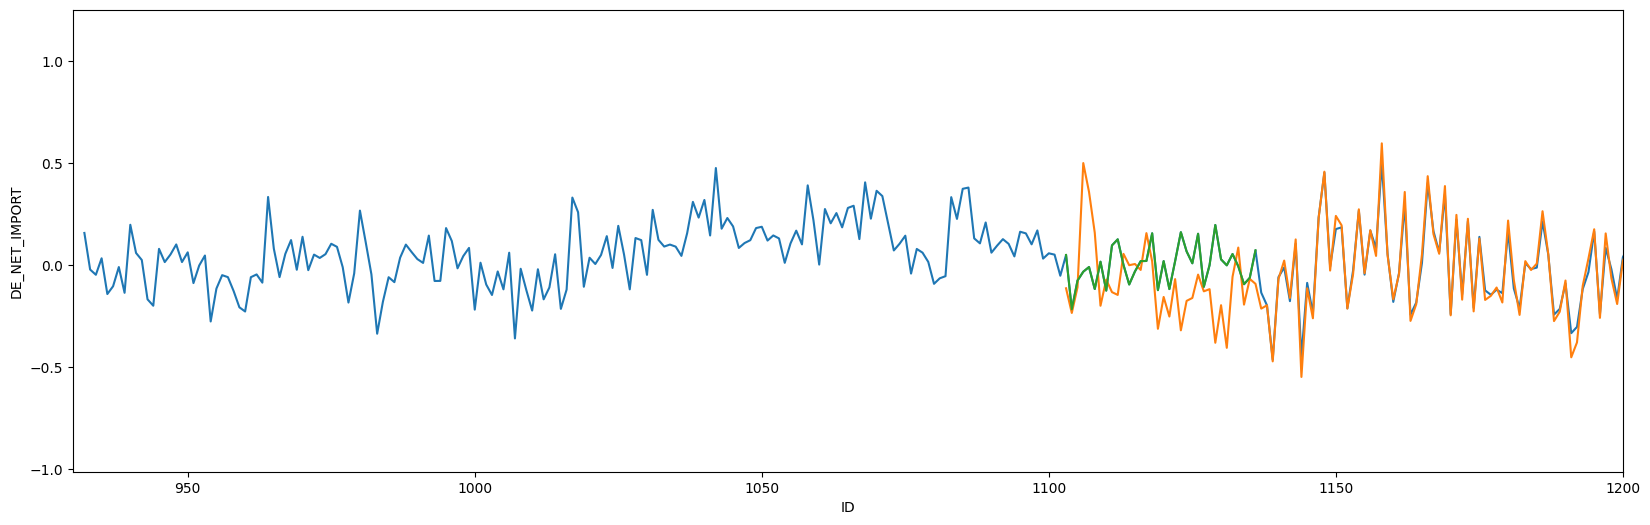

In [77]:
idx = residuals[~residuals.isna()].index
xgb_model = xgb.XGBRegressor(eta=0.3, min_child_weight=1, alpha=0.5)
x_residuals = full_fr_norm[cols].copy()
residual_train_idx = full_fr_norm[cols].loc[idx][35:].index
residual_test_idx = full_fr_norm[cols].loc[idx][:34].index
xgb_model.fit(x_residuals.loc[residual_train_idx], residuals.loc[residual_train_idx])
residual_prediction = pd.Series(data=xgb_model.predict(x_residuals), index=full_fr_norm.index)
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlim([930, 1200])
sns.lineplot(x=full_fr_norm.index, y=residual_prediction)
sns.lineplot(x=full_fr_norm.index, y=residuals)
sns.lineplot(x=residual_test_idx, y=residual_prediction[residual_test_idx])
residuals[residual_test_idx].corr(residual_prediction[residual_test_idx])

In [55]:
kf = KFold(n_splits=30, shuffle=False)
xgb_model = xgb.XGBRegressor(eta=0.2, min_child_weight=1, alpha=1)
x_residuals = full_fr_norm[cols].loc[idx]
x_residuals['ID'] = x_residuals.index
x_residuals = (x_residuals - x_residuals.mean()) / x_residuals.std()
y_residuals = residuals.loc[idx]
i = 0
for (train, test) in kf.split(x_residuals):
    i += 1
    xgb_model.fit(x_residuals.iloc[train], y_residuals.iloc[train])
    test_idx_convert = y_residuals.iloc[test].index
    train_idx_convert = y_residuals.iloc[train].index
    train_output = pd.Series(data=xgb_model.predict(x_residuals.iloc[train]), index=train_idx_convert)
    test_output = pd.Series(data=xgb_model.predict(x_residuals.iloc[test]), index=test_idx_convert)
    print(f"fold {i} test corr: {test_output.corr(y_residuals.iloc[test])}")
    print(f"fold {i} train corr: {train_output.corr(y_residuals.iloc[train])}")
    print('')

fold 1 test corr: 0.21296019964157162
fold 1 train corr: 0.992381008131457

fold 2 test corr: -0.1617348753901607
fold 2 train corr: 0.9925786326969038

fold 3 test corr: -0.030281035031732153
fold 3 train corr: 0.9933378900281795

fold 4 test corr: -0.21092402433851218
fold 4 train corr: 0.9935430696976597

fold 5 test corr: -0.0109437592247729
fold 5 train corr: 0.9934962841779309

fold 6 test corr: -0.0036643901201793665
fold 6 train corr: 0.9938880127500717

fold 7 test corr: -0.020808871088061922
fold 7 train corr: 0.99354900091169

fold 8 test corr: 0.1261221310489463
fold 8 train corr: 0.9932427732940137

fold 9 test corr: -0.02158758562177615
fold 9 train corr: 0.9931954602824543

fold 10 test corr: -0.04966164762223751
fold 10 train corr: 0.9933172417783678

fold 11 test corr: 0.05589542893896468
fold 11 train corr: 0.9928631223752972

fold 12 test corr: 0.2279784462299629
fold 12 train corr: 0.9933768622123731

fold 13 test corr: 0.012116508420044324
fold 13 train corr: 0.993

In [16]:
pd.DataFrame(data=xgb_model.feature_importances_, index=x_residuals.columns).sort_values(0, ascending=False)

,0
ID,0.149875
DE_WINDPOW,0.065745
DE_NUCLEAR,0.065550
FR_GAS,0.056149
FR_NUCLEAR,0.047672
DE_GAS,0.042335
DE_LIGNITE,0.042121
FR_RESIDUAL_LOAD,0.040705
FR_CONSUMPTION,0.039486
FR_COAL,0.039073
